# Analysis of Cancer Type Specific EMOGI Model

In [1]:
import sys, os
sys.path.append(os.path.abspath('../EMOGI'))
import gcnIO, postprocessing
import matplotlib_venn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score
plt.rc('font', family='Arial')
%matplotlib inline

## Paths

In [2]:
cancer_type = 'BRCA'

brca_model_path = '../data/GCN/training/BRCA_model_averaged/'
pancan_model_path = '../data/GCN/training/Rev1_CNA_separated_all_networks/CPDB/'
brca_patient_model_path = '../data/GCN/training/BRCA_model_patientwise/'

In [3]:
ncg_cancer_gene_path = '../data/pancancer/NCG/cancergenes_list.txt'
oncokb_cancer_gene_path = '/project/gcn/diseasegcn/data/pancancer/oncoKB/cancerGeneList.txt'
baileyetal_cancer_gene_path = '../data/pancancer/comprehensive_characterization_of_cancer_driver_genes_and_mutations/comprehensive_characterization_cancer_genes.csv'
driverdb_cancer_gene_path = '../data/pancancer/driverdb/'
ongene_oncogenes_path = '../data/pancancer/ongene_tsgene/Human_Oncogenes.txt'
tsgene_tsgs_path = '../data/pancancer/ongene_tsgene/Human_TSGs.txt'
digsee_expression_path = '/project/gcn/diseasegcn/data/pancancer/digSEE/expression/'
digsee_mutation_path = '/project/gcn/diseasegcn/data/pancancer/digSEE/mutation/'
digsee_methylation_path = '/project/gcn/diseasegcn/data/pancancer/digSEE/methylation/'

In [4]:
def get_cancer_genes_for_net(model_dir):
    if model_dir.endswith('.h5'):
        data = gcnIO.load_hdf_data(model_dir)
    else:
        data = postprocessing.get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
    nodes['label'] = np.logical_or(np.logical_or(y_train, y_test), y_val)
    # to exclude them from other databases
    known_drivers = node_names[np.logical_or(y_train.reshape(-1), y_test.reshape(-1)), 1]
    # get the NCG cancer genes
    known_cancer_genes = []
    candidate_cancer_genes = []
    n = 0
    with open(ncg_cancer_gene_path, 'r') as f:
        for line in f.readlines():
            n += 1
            if n == 1:
                continue
            l = line.strip().split('\t')
            if len(l) == 2:
                known_cancer_genes.append(l[0])
                candidate_cancer_genes.append(l[1])
            else:
                candidate_cancer_genes.append(l[0])
    known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
    candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name

    oncokb_genes = pd.read_csv(oncokb_cancer_gene_path, sep='\t')
    # remove low confidence genes
    oncokb_no_ncg_highconf = oncokb_genes#[oncokb_genes['OncoKB Annotated'] == 'Yes']
    oncokb_no_ncg_highconf = oncokb_no_ncg_highconf[oncokb_no_ncg_highconf['# of occurrence within resources (Column D-J)'] >= 3]
    # remove all NCG genes
    oncokb_no_ncg = oncokb_no_ncg_highconf[~oncokb_no_ncg_highconf['Hugo Symbol'].isin(known_cancer_genes_innet)]
    candidate_cancer_genes_innet = candidate_cancer_genes_innet[~candidate_cancer_genes_innet.isin(oncokb_no_ncg)]
    #oncokb_no_ncg = oncokb_no_ncg[~oncokb_no_ncg['Hugo Symbol'].isin(candidate_cancer_genes_innet)]
    # remove genes that are not in the network
    oncokb_innet = nodes[nodes.Name.isin(oncokb_no_ncg['Hugo Symbol'])].Name
    
    # comprehensive characterization paper genes
    cancer_genes_paper = pd.read_csv(baileyetal_cancer_gene_path, sep='\t', header=3)
    cancer_genes_paper = pd.Series(cancer_genes_paper.Gene.unique())
    cancer_genes_paper_notrain = cancer_genes_paper[~cancer_genes_paper.isin(known_drivers)]
    cancer_genes_paper_innet = nodes[nodes.Name.isin(cancer_genes_paper_notrain)].Name
    
    # driverDB
    driverdb_genes = []
    thresholds_study = {'mutation': 25, 'CNV': 5, 'methylation': 2}
    for evidence in ['mutation', 'CNV', 'methylation']:
        driverdb_data = pd.read_csv(os.path.join(driverdb_cancer_gene_path, '{}_download_tab.txt'.format(evidence)), sep='\t')
        all_driver_genes = []
        for index, row in driverdb_data.iterrows():
            all_driver_genes += [i.strip() for i in row.driver_gene.split(',') if not i.strip() == '']
        study_counts = pd.Series(all_driver_genes).value_counts()
        driverdb_genes += list(study_counts[study_counts > thresholds_study[evidence]].index)
    driverdb_genes = pd.Series(list(set(driverdb_genes)))
    driverdb_genes_notrain = driverdb_genes[~driverdb_genes.isin(known_drivers)]
    driverdb_innet = nodes[nodes.Name.isin(driverdb_genes_notrain)].Name

    # OnGene + TSGene
    oncogenes = pd.read_csv(ongene_oncogenes_path, sep='\t')
    tsgs = pd.read_csv(tsgene_tsgs_path, sep='\t')
    cancer_genes = list(set(list(oncogenes.OncogeneName) + list(tsgs.GeneSymbol)))
    oncotsgs_innet = nodes[nodes.Name.isin(cancer_genes)].Name
    oncotsgs_innet = oncotsgs_innet[~oncotsgs_innet.isin(known_drivers)]
    oncogenes_innet = oncotsgs_innet[oncotsgs_innet.isin(oncogenes.OncogeneName)]
    tsgs_innet = oncotsgs_innet[oncotsgs_innet.isin(tsgs.GeneSymbol)]

    #return oncokb_innet, oncogenes_innet, known_cancer_genes_innet
    return cancer_genes_paper_innet, candidate_cancer_genes_innet, known_cancer_genes_innet

def compute_metric(y_true, y_pred, metric='aupr', cutoff=0.5):
    if metric == 'recall':
        return recall_score(y_true=y_true, y_pred=y_pred >= cutoff)
    elif metric == 'aupr':
        return average_precision_score(y_true=y_true, y_score=y_pred)
    elif metric == 'auroc':
        return roc_auc_score(y_true=y_true, y_score=y_pred)
    elif metric == 'precision':
        return precision_score(y_true=y_true, y_pred=y_pred >= cutoff)
    else:
        print ("Metric {} unknown!".format(metric))
        return None

def get_cutoff(model_dir, predictions):
    data = postprocessing.get_training_data(model_dir)
    _, _, _, _, y_test, _, _, test_mask, node_names, _ = data
    cutoff = postprocessing.get_optimal_cutoff(predictions, node_names,
                                               test_mask, y_test, method='IS',
                                               colname='Prob_pos')
    return cutoff

## Step 1: Compute Thresholds for Both Models

In [5]:
pred_brca_model = postprocessing.load_predictions(brca_model_path)
pred_pancan_model = postprocessing.load_predictions(pancan_model_path)
pred_brca_patient_model = postprocessing.load_predictions(brca_patient_model_path)

In [6]:
thr_pancan = get_cutoff(pancan_model_path, pred_pancan_model)
thr_brca_avg = get_cutoff(brca_model_path, pred_brca_model)
thr_brca_pat = get_cutoff(brca_patient_model_path, pred_brca_patient_model)

/pkg/python-3.7.7-0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
print ("BRCA Model Threshold: {0:.3f}".format(thr_brca_avg))
print ("BRCA Patient Model Threshold: {0:.3f}".format(thr_brca_pat))
print ("Pancancer Model Threshold: {0:.3f}".format(thr_pancan))

BRCA Model Threshold: 0.639
BRCA Patient Model Threshold: 0.475
Pancancer Model Threshold: 0.809


## Step 2: Compare the Predictions

In [8]:
preds_brca = pred_brca_model[pred_brca_model.Prob_pos >= thr_brca_avg]
print ("BRCA Model Predicts {} Cancer Genes".format(preds_brca.shape[0]))
preds_pancan = pred_pancan_model[pred_pancan_model.Prob_pos >= thr_pancan]
print ("Pancancer Model Predicts {} Cancer Genes".format(preds_pancan.shape[0]))
preds_brca_pat = pred_brca_patient_model[pred_brca_patient_model.Prob_pos >= thr_brca_pat]
print ("BRCA Patient Model Predicts {} Cancer Genes".format(preds_brca_pat.shape[0]))
missed_by_brca_not_pancan = preds_pancan[~preds_pancan.index.isin(preds_brca.index)]
missed_by_brca_not_pancan.head(20)

BRCA Model Predicts 2962 Cancer Genes
Pancancer Model Predicts 3704 Cancer Genes
BRCA Patient Model Predicts 3232 Cancer Genes


,Name,label,Num_Pos,Prob_pos,Std_Pred
ID,,,,,
ENSG00000131018,SYNE1,False,10,1.000,0.000
ENSG00000143631,FLG,False,10,1.000,0.000
ENSG00000198400,NTRK1,True,10,1.000,0.000
ENSG00000181555,SETD2,True,10,1.000,0.000
ENSG00000181143,MUC16,True,10,1.000,0.000
ENSG00000055609,KMT2C,True,10,1.000,0.000
ENSG00000128731,HERC2,False,10,1.000,0.000
ENSG00000083857,FAT1,True,10,1.000,0.000
ENSG00000288121,MDN1,False,10,1.000,0.000


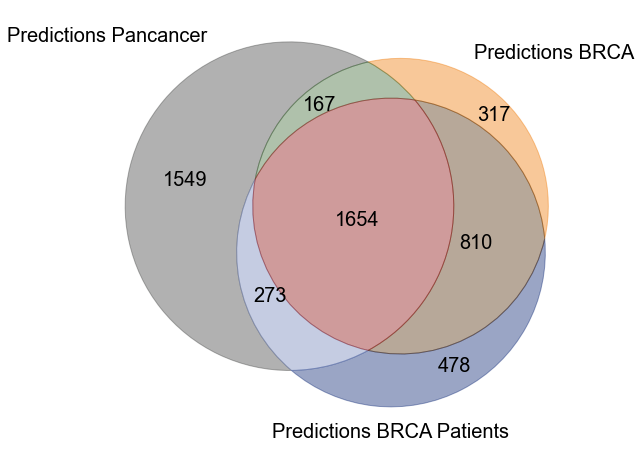

In [9]:
fig = plt.figure(figsize=(10, 8))
v = matplotlib_venn.venn3([set(preds_pancan.index), set(preds_brca.index), set(preds_brca_pat.index)],
                      set_labels=['Predictions Pancancer', 'Predictions BRCA', 'Predictions BRCA Patients'])
if not v.get_patch_by_id('10') is None:
    v.get_patch_by_id('10').set_color('#3d3e3d')
    v.get_label_by_id('10').set_fontsize(20)
if not v.get_patch_by_id('11') is None:
    v.get_patch_by_id('11').set_color('#37652d')
    v.get_label_by_id('11').set_fontsize(20)
v.get_patch_by_id('011').set_color('#4d2600')
v.get_label_by_id('A').set_fontsize(20)
v.get_label_by_id('B').set_fontsize(20)
v.get_label_by_id('C').set_fontsize(20)
if not v.get_patch_by_id('01') is None:
    v.get_patch_by_id('01').set_color('#ee7600')
    v.get_label_by_id('01').set_fontsize(20)
if not v.get_patch_by_id('111') is None and not v.get_patch_by_id('101') is None:
    v.get_label_by_id('111').set_fontsize(20)
    v.get_label_by_id('101').set_fontsize(20)
    v.get_patch_by_id('111').set_color('#890707')
    v.get_patch_by_id('101').set_color('#6E80B7')
if not v.get_patch_by_id('011') is None:
    v.get_label_by_id('011').set_fontsize(20)
if not v.get_patch_by_id('001') is None:
    v.get_patch_by_id('001').set_color('#031F6F')
    v.get_label_by_id('001').set_fontsize(20)

### Check Most Mutated BRCA Genes According to TCGA

In [10]:
most_mutated_brca_genes = ['TP53', 'PIK3CA', 'CDH1', 'GATA3', 'KMT2C', 'MAP3K1', 'PTEN', 'NCOR1',
                           'NF1', 'RUNX1', 'ARID1A', 'PIK3R1', 'KMT2D', 'MAP2K4', 'RNF213', 'SPEN',
                           'FAT1', 'AKAP9', 'MYH9', 'MED12'] #'CYP19A1' BRCA gene according to literature
print ("Highly Mutated BRCA Genes Missed by EMOGI BRCA Model")
missed_by_brca_not_pancan[missed_by_brca_not_pancan.Name.isin(most_mutated_brca_genes)]

Highly Mutated BRCA Genes Missed by EMOGI BRCA Model


,Name,label,Num_Pos,Prob_pos,Std_Pred
ID,,,,,
ENSG00000055609,KMT2C,True,10,1.000,0.000
ENSG00000083857,FAT1,True,10,1.000,0.000
ENSG00000173821,RNF213,True,10,1.000,0.000
ENSG00000107485,GATA3,True,10,0.994,0.004


## Sensitivity Analysis

In [19]:
comprehensive, ncg_cand, ncg_known = get_cancer_genes_for_net(brca_model_path)

data = postprocessing.get_training_data(brca_model_path)
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
brca_test_genes = pd.DataFrame(node_names[y_test.reshape(-1) == 1], columns=['ID', 'Name'])
brca_train_genes = pd.DataFrame(node_names[np.logical_or(y_train.reshape(-1), y_val.reshape(-1)) == 1], columns=['ID', 'Name'])

data = postprocessing.get_training_data(brca_patient_model_path)
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
brca_pat_test_genes = pd.DataFrame(node_names[y_test.reshape(-1) == 1], columns=['ID', 'Name'])
brca_pat_train_genes = pd.DataFrame(node_names[np.logical_or(y_train.reshape(-1), y_val.reshape(-1)) == 1], columns=['ID', 'Name'])

data = postprocessing.get_training_data(pancan_model_path)
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
pancan_test_genes = pd.DataFrame(node_names[y_test.reshape(-1) == 1], columns=['ID', 'Name'])
pancan_train_genes = pd.DataFrame(node_names[np.logical_or(y_train.reshape(-1), y_val.reshape(-1)) == 1], columns=['ID', 'Name'])

brca_train_genes_nooverlap = brca_train_genes#[~brca_train_genes.Name.isin(pancan_train_genes.Name)]
brca_test_genes_nooverlap = brca_test_genes[~brca_test_genes.Name.isin(pancan_train_genes.Name)]

print ("{} BRCA training genes with overlaps removed".format(brca_train_genes_nooverlap.shape[0]))
print ("{} BRCA testing genes with overlaps removed".format(brca_test_genes_nooverlap.shape[0]))

364 BRCA training genes with overlaps removed
80 BRCA testing genes with overlaps removed


In [20]:
brcalabels = pred_brca_model[pred_brca_model.label].Name

labels = ['Pancancer', 'BRCA Averaged', 'BRCA Patient']
c = 0
for p in [preds_pancan, preds_brca, preds_brca_pat]:
    sensitivity = p[p.Name.isin(brca_test_genes_nooverlap.Name)].shape[0] / brca_test_genes_nooverlap.shape[0]
    print ("Sensitivity of {0} on BRCA Test Genes: {1:.2f}".format(labels[c], sensitivity))
    c += 1

Sensitivity of Pancancer on BRCA Test Genes: 0.46
Sensitivity of BRCA Averaged on BRCA Test Genes: 0.39
Sensitivity of BRCA Patient on BRCA Test Genes: 0.46


In [21]:
brcalabels = pred_brca_model[pred_brca_model.label].Name

c = 0
for p in [preds_pancan, preds_brca, preds_brca_pat]:
    sensitivity = p[p.Name.isin(brca_train_genes_nooverlap.Name)].shape[0] / brca_train_genes_nooverlap.shape[0]
    print ("Sensitivity of {0} on BRCA Training Genes: {1:.2f}".format(labels[c], sensitivity))
    c += 1

Sensitivity of Pancancer on BRCA Training Genes: 0.68
Sensitivity of BRCA Averaged on BRCA Training Genes: 0.54
Sensitivity of BRCA Patient on BRCA Training Genes: 0.68


## PR Curve on the Test Sets

/project/gcn/diseasegcn/EMOGI/postprocessing.py:676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_pred_test.drop_duplicates(inplace=True)
/project/gcn/diseasegcn/EMOGI/postprocessing.py:676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_pred_test.drop_duplicates(inplace=True)
/pkg/python-3.7.7-0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also r

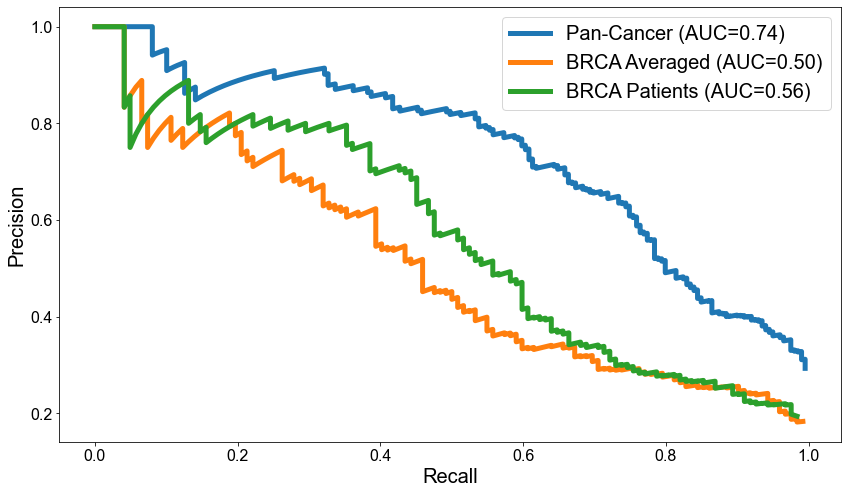

In [56]:
fig = plt.figure(figsize=(14, 8))
c = 0
test_set_performances = []
labels = ['Pan-Cancer', 'BRCA Averaged', 'BRCA Patients']
for model_dir in [pancan_model_path, brca_model_path, brca_patient_model_path]:
    data = postprocessing.get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    pred_all, pred_test = postprocessing.compute_predictions_competitors(model_dir,
                                                                         network_name='CPDB',
                                                                         plot_correlations=False
                                                                        )
    test_set_performances.append(pred_test)
    y_true = y_test[test_mask == 1, 0]
    pr, rec, thresholds = precision_recall_curve(y_true=y_true, probas_pred=pred_test['EMOGI'])
    aupr = average_precision_score(y_true=y_true, y_score=pred_test['EMOGI'])
    plt.plot(rec[1:], pr[1:], lw=5, label='{0}'.format(labels[c] + ' (AUC={0:.2f})'.format(aupr)))
    c += 1

random_y = y_true.sum() / (y_true.sum() + y_true.shape[0] - y_true.sum())
#plt.plot([0, 1], [random_y, random_y], color='gray', lw=3, linestyle='--', label='Random')
plt.legend(fontsize=20)
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
fig.savefig('../data/cancer_specific/brca_pr_curve.svg')

## Test Set Performance for all Tools

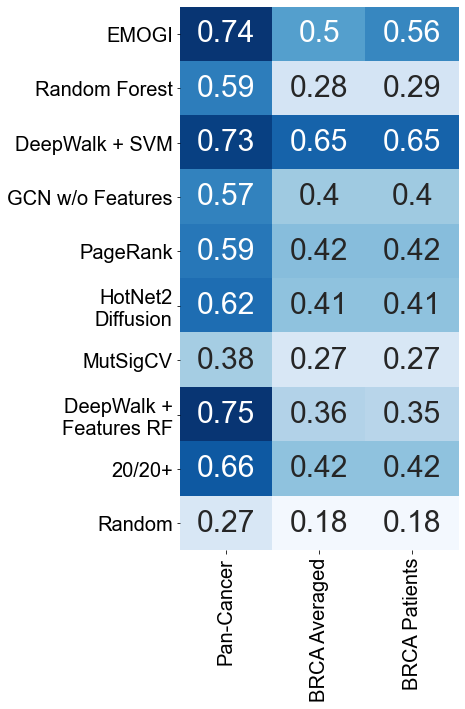

In [54]:
c = 0
methods = [('EMOGI', 'EMOGI'), ('Random Forest', 'Random_Forest'),
           ('DeepWalk + SVM', 'DeepWalk'), ('GCN w/o Features', 'GCN_Featureless'),
           ('PageRank', 'PageRank'), ('HotNet2\nDiffusion', 'RWR'),
           ('MutSigCV', 'MutSigCV'), ('DeepWalk +\nFeatures RF', 'RF_dwfeat'), ('20/20+', '2020plus')]
metrics_all = pd.DataFrame(index=[m[0] for m in methods])
random_metrics = []
for model_dir in [pancan_model_path, brca_model_path, brca_patient_model_path]:
    data = postprocessing.get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    y_true = y_test[test_mask == 1, 0]
    random_aupr = y_true.sum() / (y_true.sum() + y_true.shape[0] - y_true.sum())
    random_metrics.append(random_aupr)
    metric_values = []
    for name, colname in methods:
        aupr = average_precision_score(y_true=y_test[test_mask == 1, 0], y_score=test_set_performances[c][colname])
        metric_values.append(aupr)
    metrics_all[labels[c]] = metric_values
    c += 1

metrics_all.loc['Random', :] = random_metrics
fig = plt.figure(figsize=(5, 10))
cmap = sns.color_palette("Blues", n_colors=50)

sns.heatmap(metrics_all, cbar=False, cmap=cmap, cbar_kws={'use_gridspec': False, 'orientation': 'vertical'},
            annot=True, annot_kws={"size": 30, 'weight': 'medium'})
_ = plt.gca().set_xticklabels(metrics_all.columns, rotation=90, fontsize=20)
_ = plt.gca().set_yticklabels(metrics_all.index, rotation=0, fontsize=20)
fig.savefig('../data/cancer_specific/heatmap_all.svg')

In [51]:
ncg_cancer_gene_path = '../data/pancancer/NCG/cancergenes_list.txt'
known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open(ncg_cancer_gene_path, 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

In [53]:
brca_missed = pred_brca_model[pred_brca_model.label]
brca_missed = brca_missed[brca_missed.Prob_pos < thr_pr_brca]
brca_missed = brca_missed[~brca_missed.Name.isin(preds_brca_pat.Name)]
brca_missed_ncg = brca_missed[brca_missed.Name.isin(known_cancer_genes)]
#candidates_missed_by_brca_models = brca_missed_ncg[brca_missed_ncg.index.isin(preds_pancan.index)]
candidates_missed_by_brca_models = brca_missed[brca_missed.index.isin(preds_pancan.index)]
candidates_missed_by_brca_models.head(50)

,Name,label,Num_Pos,Prob_pos,Std_Pred,NCG_Known_Cancer_Gene,NCG_Candidate_Cancer_Gene,OncoKB_Cancer_Gene,Bailey_et_al_Cancer_Gene,ONGene_Oncogene
ID,,,,,,,,,,
ENSG00000135930,EIF4E2,True,10,0.849,0.109,False,False,False,False,False
ENSG00000102974,CTCF,True,10,0.818,0.089,True,False,True,True,False
ENSG00000100503,NIN,True,10,0.817,0.123,True,False,False,False,False
ENSG00000112312,GMNN,True,10,0.816,0.133,False,False,False,False,True
ENSG00000112096,SOD2,True,10,0.807,0.104,False,False,False,False,False
ENSG00000147677,EIF3H,True,10,0.798,0.092,False,False,False,False,False
ENSG00000049768,FOXP3,True,10,0.793,0.130,False,False,False,False,False
ENSG00000117713,ARID1A,True,10,0.789,0.113,True,False,True,True,False
ENSG00000174744,BRMS1,True,10,0.788,0.119,False,False,False,False,False


## Where is the training data from?

In [48]:
data = postprocessing.get_training_data(brca_model_path)
comprehensive, ncg_cand, ncg_known = get_cancer_genes_for_net(brca_model_path)
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data

cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv')
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
positives = nodes[np.logical_or(np.logical_or(y_train, y_test), y_val)]
positives[positives.Name.isin(cgc['Gene Symbol'])]

positives['evidence'] = 'None'
for evidence_type in ['mutation', 'methylation', 'expression']:
    fname = '../data/pancancer/digSEE/{0}/{0}_{1}.txt'.format(evidence_type, cancer_type.upper())
    evidence = pd.read_csv(fname, sep='\t')
    high_scores = evidence[evidence['EVIDENCE SENTENCE SCORE'] >= 0.8]
    positives.loc[positives.Name.isin(high_scores['GENE SYMBOL'].tolist()),'evidence'] = evidence_type
positives.loc[positives.Name.isin(cgc['Gene Symbol']), 'evidence'] = 'CGC'

positives.evidence.value_counts()

/pkg/python-3.7.7-0/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/pkg/python-3.7.7-0/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/pkg/python-3.7.7-0/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

expression    205
mutation      165
CGC           116
Name: evidence, dtype: int64